# 1. Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

In [2]:
PKG_DIR="/content/drive/MyDrive/offline_packages"

!pip install --no-index --find-links="$PKG_DIR" transformers datasets evaluate

Looking in links: /content/drive/MyDrive/offline_packages
Processing ./drive/MyDrive/offline_packages/evaluate-0.4.6-py3-none-any.whl


In [3]:
from transformers import AutoConfig,AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments, Trainer
import evaluate

# 2. EDA

In [4]:
df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df[['title','text']]

,title,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...
...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...
20797,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...
20798,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20757 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [7]:
print(df.isna().sum())
df.dropna(inplace=True)
print("\nDone Deleting\n")
print(df.isna().sum())

id           0
title      558
author    1957
text        43
label        0
dtype: int64

Done Deleting

id        0
title     0
author    0
text      0
label     0
dtype: int64


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df['label'].value_counts()

,count
label,
0,10361
1,7920


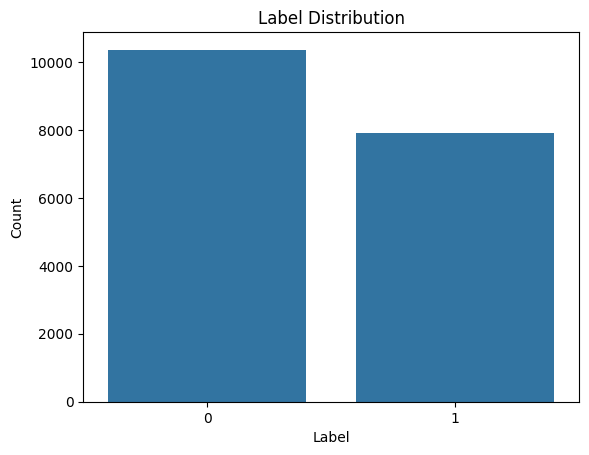

In [10]:
sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show()

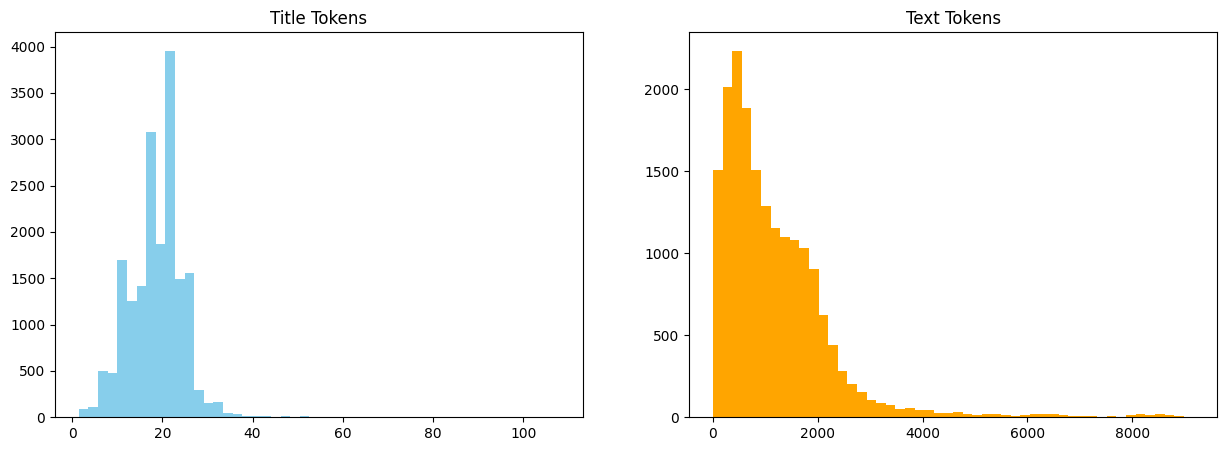

In [11]:
# 1.5 tokens per word on average
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)

fix,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

In [12]:
df.rename(columns={'label':'labels'}, inplace=True)
df.head()

,id,title,author,text,labels,title_tokens,text_tokens
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,21.0,1230.0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,13.5,1065.0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,10.5,1899.0
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15.0,835.5
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,21.0,231.0


# 3. Train-Test-Split

In [13]:
train,test = train_test_split(df, test_size=0.3, random_state=42,stratify=df['labels'])
test,validation = train_test_split(test, test_size=1/3, random_state=42,stratify=test['labels'])

print(train.shape,test.shape,validation.shape)

(12796, 7) (3656, 7) (1829, 7)


# 4. Dataframe -> HF Dataset

In [14]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train,preserve_index=False),
    'test': Dataset.from_pandas(test,preserve_index=False),
    'validation': Dataset.from_pandas(validation,preserve_index=False)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'labels', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'labels', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'labels', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

# 5. label2id, id2label

In [15]:
label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

# 6. Model, Tokenizer

In [16]:
distilbert_dir = '/content/drive/MyDrive/offline_models/distilbert-base-uncased'
tinybert_dir = '/content/drive/MyDrive/offline_models/tinybert'

In [17]:
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_dir,local_files_only=True)
distilber_model = AutoModelForSequenceClassification.from_pretrained(distilbert_dir,local_files_only=True,num_labels=2,id2label=id2label,label2id=label2id)

tinybert_tokenizer = AutoTokenizer.from_pretrained(tinybert_dir,local_files_only=True)
tinybert_model = AutoModelForSequenceClassification.from_pretrained(tinybert_dir,local_files_only=True,num_labels=2,id2label=id2label,label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/offline_models/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/offline_models/tinybert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 7. Tokenization



1.   combine title+text
2.   text only



In [18]:
def tokenize(batch):
  return tinybert_tokenizer(batch['title'], batch['text'], truncation=True,padding=True,max_length = 512)

In [19]:
tokenized_dataframe = dataset.map(tokenize, batched=True, batch_size=None)
tokenized_dataframe

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'labels', 'title_tokens', 'text_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'labels', 'title_tokens', 'text_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'labels', 'title_tokens', 'text_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1829
    })
})

In [20]:
print(dataset['train'][0],"\n")
print(tokenize(dataset['train'][0]))

{'id': 20451, 'title': 'Donald Trump Gettysburg Address RECAP', 'author': 'Truth Broadcast Network', 'text': "7 hours ago 3   reports on What You Need to Know About the 'Alt Right' Click Here to Support!   Get the New AMTV Coffee Cup Rogue Black... Now on Sale!! $9.99\uf44a\uf3fb AMTV https://goo.gl/XKnuWA  ", 'labels': 1, 'title_tokens': 7.5, 'text_tokens': 49.5} 

{'input_ids': [101, 6221, 8398, 22577, 4769, 28667, 9331, 102, 1021, 2847, 3283, 1017, 4311, 2006, 2054, 2017, 2342, 2000, 2113, 2055, 1996, 1005, 12456, 2157, 1005, 11562, 2182, 2000, 2490, 999, 2131, 1996, 2047, 2572, 9189, 4157, 2452, 12406, 2304, 1012, 1012, 1012, 2085, 2006, 5096, 999, 999, 1002, 1023, 1012, 5585, 2572, 9189, 16770, 1024, 1013, 1013, 27571, 1012, 1043, 2140, 1013, 1060, 2243, 11231, 4213, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [21]:
final_dataset = tokenized_dataframe.remove_columns(['title','text','id','author'])
final_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'title_tokens', 'text_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['labels', 'title_tokens', 'text_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['labels', 'title_tokens', 'text_tokens', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1829
    })
})

# 8. Compute metrics

In [22]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
  predictions,labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 9. Training args and trainer

In [23]:
batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
                                  output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  eval_strategy = 'epoch',
                                  num_train_epochs = 3,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
)

In [24]:
trainer = Trainer(
    model = tinybert_model,
    args = training_args,
    train_dataset = final_dataset['train'],
    eval_dataset = final_dataset['validation'],
    tokenizer = tinybert_tokenizer,
    compute_metrics = compute_metrics,
)

/tmp/ipython-input-1295999482.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# 10. Model Training

In [25]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pavan220405 (pavan220405-iit-ropar-tif) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.046162,0.989612
2,0.218000,0.016922,0.996720
3,0.017500,0.015735,0.997266


TrainOutput(global_step=1200, training_loss=0.09965561777353286, metrics={'train_runtime': 494.3633, 'train_samples_per_second': 77.651, 'train_steps_per_second': 2.427, 'total_flos': 550445387046912.0, 'train_loss': 0.09965561777353286, 'epoch': 3.0})

# 11. Model Evaluation

In [26]:
preds = trainer.predict(final_dataset['test'])
preds.metrics

{'test_loss': 0.011287638917565346,
 'test_accuracy': 0.9978118161925602,
 'test_runtime': 13.0795,
 'test_samples_per_second': 279.521,
 'test_steps_per_second': 8.792}

In [27]:
from sklearn.metrics import accuracy_score

y_preds = np.argmax(preds.predictions, axis=1)
y_true = dataset['test']['labels'][:]

print(accuracy_score(y_true, y_preds))

0.9978118161925602


# 12. Comparing with DistilBERT


In [28]:
distilbert_dir = '/content/drive/MyDrive/offline_models/distilbert-base-uncased'

distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_dir,local_files_only=True)
distilbert_config = AutoConfig.from_pretrained(distilbert_dir,local_files_only=True,num_labels=2,id2label=id2label,label2id=label2id)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(distilbert_dir,local_files_only=True,config = distilbert_config)

def distil_tokenize(batch):
  return distilbert_tokenizer(batch['title'], batch['text'], truncation=True,padding=True,max_length = 512)

dataset_distil = dataset.map(distil_tokenize, batched=True, batch_size=None)
final_dataset_distil = dataset_distil.remove_columns(['title','text','id','author'])

trainer_distil = Trainer(
    model = distilbert_model,
    args = training_args,
    train_dataset = final_dataset_distil['train'],
    eval_dataset = final_dataset_distil['validation'],
    tokenizer = distilbert_tokenizer,
    compute_metrics = compute_metrics,
)

trainer_distil.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/offline_models/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

/tmp/ipython-input-81550133.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distil = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.009744,0.997813
2,0.059400,0.014965,0.996173
3,0.004500,0.008891,0.997813


TrainOutput(global_step=1200, training_loss=0.027100048462549844, metrics={'train_runtime': 1842.8176, 'train_samples_per_second': 20.831, 'train_steps_per_second': 0.651, 'total_flos': 5085158499606528.0, 'train_loss': 0.027100048462549844, 'epoch': 3.0})

In [31]:
preds_distil = trainer_distil.predict(final_dataset_distil['test'])
preds_distil.metrics

{'test_loss': 0.002549974247813225,
 'test_accuracy': 0.99945295404814,
 'test_runtime': 56.9653,
 'test_samples_per_second': 64.179,
 'test_steps_per_second': 2.019}

In [33]:
y_preds_distil = np.argmax(preds_distil.predictions, axis=1)
y_true_distil = dataset['test']['labels'][:]

print(accuracy_score(y_true_distil, y_preds_distil))

0.99945295404814


# Comparision

In [42]:
comparision_table = pd.DataFrame({
    'Models' : ['DistilBERT','TinyBERT'],
    'Test Accuracy' : [preds_distil.metrics['test_accuracy'],preds.metrics['test_accuracy']],
    'Training Time' : [1842.8176,494.3633],
    'Inference Time' : [preds_distil.metrics['test_runtime'],preds.metrics['test_runtime']]
})

comparision_table

,Models,Test Accuracy,Training Time,Inference Time
0,DistilBERT,0.999453,1842.8176,56.9653
1,TinyBERT,0.997812,494.3633,13.0795
